# **Proyecto 10a**: Estudio del rendimiento de RNNs y su comportamiento a distintos largos de secuencia.
#Inteligencia Computacional EL4106-1 Primavera 2023

**Profesor**
- Pablo Estévez

**Profesor Auxiliar**
- Juan Urrutia

**Ayudante**
- Alejandro Luzanto

**Estudiantes:**
- Agustín González
- Diego Torreblanca

## Importar librerías y archivos

Importamos librerías a utilizar

In [ ]:
import torch
import torch.nn as nn
import torchaudio
import os
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
import urllib.request
from sklearn.model_selection import train_test_split
from sklearn.metrics import ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import seaborn as sns
import time
from tqdm.notebook import tqdm
from pprint import pprint
from typing import Tuple, Callable, Optional, List
from torchaudio.datasets.utils import _load_waveform

Versión de `Python 3`

In [ ]:
!python --version

Python 3.10.12


Importamos lista con archivos de audio que serán usados en validación, entrenamiento y testeo.

In [ ]:
files_dict = {
    "train_list.txt": "1rkwGTHlMWp1HAUSZK2zMhzzYGcb7Tb3y",
    "test_list.txt": "1dsMqujN1uFEHjZy77d2K64NwIiN4vibv",
    "val_list.txt": "1Q6nP5QZFvSO3sP6-1_Q7aIXgiod6LsJj"
}

for file_name, file_url in files_dict.items():

    url = f'https://drive.usercontent.google.com/download?id={file_url}&export=download'
    urllib.request.urlretrieve(url, "./" + file_name)

## Carga de los datasets

In [ ]:
# Se definen las labels que serán válidas
VALID_LABELS = ["yes", "no", "up", "down", "left", "right", "on",
"off", "stop", "go", "unknown word"]

# Cantidad de MFCC (coeficientes)
N_MFCC = 14

# Importar Dataset
# Clase que nos permite cargar el dataset y recorrer solo los archivos que nos interesa recorrer
# por cada caso (validación, entrenamiento, testeo)
class CustomSpeechCommands(torchaudio.datasets.SPEECHCOMMANDS):

    def __init__(self, subset_to_download: str = "all",
                 load_in_mem: bool = True, mem_transform: Optional[Callable] = None):
        super().__init__("", download=True, subset=None, url="speech_commands_v0.02")

        self._data = None
        self._transform = None
        self._in_mem = load_in_mem

        if subset_to_download == "validation":
            self._walker = self.load_list("val_list.txt")
        elif subset_to_download == "testing":
            self._walker = self.load_list("test_list.txt")
        elif subset_to_download == "training":
            self._walker = self.load_list("train_list.txt")
        else:
            raise RuntimeError("Invalid subset")

        # If to save in memory
        if self._in_mem:
            self._transform = mem_transform
            self._data = self.memory_load()
            print(f"Loaded {subset_to_download} data in memory.")


    def load_list(self, *filenames) -> List[str]:
        """Carga y devuelve las rutas a los archivos de audio a utilizar"""

        output = []
        for filename in filenames:
            filepath = os.path.join("", filename)
            with open(filepath) as fileobj:
                output += [os.path.normpath(
                    os.path.join("./SpeechCommands/speech_commands_v0.02/",
                                 line.strip())) for line in fileobj]
        return output

    def memory_load(self) -> List[Tuple]:
        """Carga en memoria los audios y etiquetas, aplica target_transform de haber"""

        number_of_audios = len(self._walker)
        data = [None] * number_of_audios
        longest_wv = 0
        for n in range(number_of_audios):
            metadata = self.get_metadata(n)
            waveform = _load_waveform(self._archive, metadata[0], metadata[1])

            longest_wv = waveform.shape[1] if waveform.shape[1] > longest_wv else longest_wv

            data[n] = (waveform,) + metadata[1:]

            if n % 300 == 0:
                print(f"\rLoading data in memory - {n / number_of_audios * 100:.2f}%", end="")

        if self._transform:
            print("\rApplying target transform to data in memory", end="")

            step_size = 300
            for batch_idx in range(0, len(data), step_size):
                end_idx = batch_idx + step_size

                data[batch_idx:end_idx] = self._transform(
                                                        data[batch_idx:end_idx],
                                                        torch.empty((1, longest_wv))
                                                        )

            print("\r", end="")

        return data


    def __getitem__(self, n: int) -> Tuple[torch.Tensor, int, str, str, int]:
        """Load the n-th sample from the dataset.

        Args:
            n (int): The index of the sample to be loaded

        Returns:
            Tuple of the following items;

            Tensor:
                Waveform
            int:
                Sample rate
            str:
                Label
            str:
                Speaker ID
            int:
                Utterance number
        """

        if self._in_mem:
            return self._data[n]
        else:
            metadata = self.get_metadata(n)
            waveform = _load_waveform(self._archive, metadata[0], metadata[1])
            return (waveform,) + metadata[1:]


def label_to_tensor(label: str) -> torch.Tensor:
    """Dado una etiqueta entrega un tensor con un número que representa el índice de la etiqueta"""

    if label.lower() in VALID_LABELS:
        index = VALID_LABELS.index(label)
    else:
        index = len(VALID_LABELS) - 1

    return torch.tensor(index)


def target_transform(batch, pad_to_length: torch.Tensor = torch.empty([1, 1])):
    """Procesa los audios y etiquetas para que tengan el formato adecuado"""
    WINDOW_SIZE = 40e-3 # Ventana de 40 ms de forma predeterminada
    # WINDOW_SIZE = 80e-3 # Ventana de 80 ms para estudiar la red RNN Vanilla
    # WINDOW_SIZE = 120e-3 # Ventana de 120 ms para estudiar la red RNN Vanilla
    SAMPLE_RATE = 16_000
    N_FFT = int(SAMPLE_RATE * WINDOW_SIZE)
    HOP_LENGTH = N_FFT // 2 # Overlap del 50%

    # Se recupera cada audio y etiqueta del batch para procesar
    audios, labels = [], []

    for audio, _, label, *_ in batch:
        audios.append(audio.t())
        labels.append(label_to_tensor(label))
    # Tensor con las etiquetas
    labels = torch.stack(labels)

    # Los audios tienen largos distintos, por lo que se rellenan con ceros para que queden todos
    # iguales.
    audios = torch.nn.utils.rnn.pad_sequence(audios + [pad_to_length.t()],
                                              batch_first=True)\
                                .squeeze()
    audios = audios[:-1]
    # Se crea el transformador a MCC
    mfcc = torchaudio.transforms.MFCC(sample_rate=SAMPLE_RATE, n_mfcc=N_MFCC,
                                   melkwargs= {
                                       "hop_length": HOP_LENGTH,
                                       "n_fft": N_FFT
                                   })
    # Se calculan los MFCC de los audios
    mfcc_vals = mfcc(audios)
    # Se calcula los delta de los audios
    delta = torchaudio.functional.compute_deltas(mfcc_vals) # (batch, 14, 51) cambiar la cantidad de features
    # Se calcula los delta-delta de los audios
    delta2 = torchaudio.functional.compute_deltas(delta)
    # Se concatenan las 3 características, compartiendo la dimensión del tiempo
    audios = torch.cat((mfcc_vals, delta, delta2), dim=1).permute(0, 2, 1) # BATCH, LENGTH, INPUT

    audios_with_label = list(zip(audios, labels))

    return audios_with_label

In [ ]:
# Se crean los datasets
train_dataset = CustomSpeechCommands("training", mem_transform=target_transform)
val_dataset = CustomSpeechCommands("validation", mem_transform=target_transform)
test_dataset = CustomSpeechCommands("testing", mem_transform=target_transform)

100%|██████████| 2.26G/2.26G [00:16<00:00, 150MB/s]


Loaded training data in memory.
Loaded validation data in memory.
Loaded testing data in memory.


In [ ]:
# Dataloaders para los 3 tipos de audios
BATCH_SIZE = 128
SHUFFLE_DL = True

# Se asume que se usará GPU
train_loader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True,
    num_workers=2)

val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True)

test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=SHUFFLE_DL,
    pin_memory=True)

Escuchamos uno de los audios

In [ ]:
# Zero
SAMPLE_RATE = 16000
ipd.Audio(train_dataset[-1][0], rate=SAMPLE_RATE)

## Gráficos

Gráficos de las curvas de entrenamiento y validación

In [ ]:
def show_curves(all_curves, model_name):

    min = np.inf
    for curve in all_curves:
        new_min = len(curve["val_loss"])
        min = new_min if new_min < min else min

    for curve in all_curves:
        for i in curve.keys():
            curve[i] = curve[i][:min]

    final_curve_means = {k: np.mean([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}
    final_curve_stds = {k: np.std([c[k] for c in all_curves], axis=0) for k in all_curves[0].keys()}

    fig, ax = plt.subplots(1, 2, figsize=(13, 5))
    fig.set_facecolor('white')

    epochs = np.arange(len(final_curve_means["val_loss"])) + 1

    ax[0].plot(epochs, final_curve_means['val_loss'], label='validation')
    ax[0].plot(epochs, final_curve_means['train_loss'], label='training')
    ax[0].fill_between(epochs, y1=final_curve_means["val_loss"] - final_curve_stds["val_loss"], y2=final_curve_means["val_loss"] + final_curve_stds["val_loss"], alpha=.5)
    ax[0].fill_between(epochs, y1=final_curve_means["train_loss"] - final_curve_stds["train_loss"], y2=final_curve_means["train_loss"] + final_curve_stds["train_loss"], alpha=.5)
    ax[0].set_xlabel('Epoch')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Loss evolution during training for ' + model_name)
    ax[0].legend()
    ax[0].grid(True)

    ax[1].plot(epochs, final_curve_means['val_acc'], label='validation')
    ax[1].plot(epochs, final_curve_means['train_acc'], label='training')
    ax[1].fill_between(epochs, y1=final_curve_means["val_acc"] - final_curve_stds["val_acc"], y2=final_curve_means["val_acc"] + final_curve_stds["val_acc"], alpha=.5)
    ax[1].fill_between(epochs, y1=final_curve_means["train_acc"] - final_curve_stds["train_acc"], y2=final_curve_means["train_acc"] + final_curve_stds["train_acc"], alpha=.5)
    ax[1].set_xlabel('Epoch')
    ax[1].set_ylabel('Accuracy')
    ax[1].set_title('Accuracy evolution during training for ' + model_name)
    ax[1].legend()
    ax[1].grid(True)

    plt.show()

Métricas y Matriz de Confusión

In [ ]:
def confusion_matrix(model, dataloader, model_name):
    model.cpu()
    model.eval()
    y_true = []
    y_pred = []

    for x, y in dataloader:
        y_true.append(y)
        y_pred.append(model(x).argmax(dim=1))

    y_true = torch.cat(y_true)
    y_pred = torch.cat(y_pred)

    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='macro')
    recall = recall_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')

    print(model_name + " metrics\n")
    print(f"Accuracy: {accuracy * 100:.2f}%")
    print(f"Precision: {precision * 100:.2f}%")
    print(f"Recall: {recall * 100:.2f}%")
    print(f"F1-score: {f1 * 100:.2f}%")

    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, display_labels=VALID_LABELS,
                                            xticks_rotation=30, normalize="all")
    plt.title("Confusion Matrix for " + model_name)
    plt.show()

## Funciones/Clases de entrenamiento

In [ ]:
class EarlyStopping:
    def __init__(self, n_epochs_tolerance):
        self.n_epochs_tolerance = n_epochs_tolerance
        self.epochs_with_no_improvement = 0
        self.best_loss = np.inf

    def __call__(self, val_loss):
        # En cada llamada aumentamos el número de épocas en que no hemos mejorado
        self.epochs_with_no_improvement += 1

        if val_loss <= self.best_loss:
            # Si efectivamente mejoramos (menor loss de validación) reiniciamos el número de épocas sin mejora
            self.best_loss = val_loss
            self.epochs_with_no_improvement = 0

        # Retornamos True si debemos detenernos y False si aún no
        # Nos detenemos cuando el número de épocas sin mejora es mayor o igual que el número de épocas de tolerancia
        return self.epochs_with_no_improvement >= self.n_epochs_tolerance

def train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu):
    # Predicción
    y_predicted = model(x_batch)

    # Cálculo de loss
    loss = criterion(y_predicted, y_batch)

    # Actualización de parámetros
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return y_predicted, loss


def evaluate(val_loader, model, criterion, use_gpu):
    cumulative_loss = 0
    cumulative_predictions = 0
    data_count = 0

    for x_val, y_val in val_loader:
        if use_gpu:
            x_val = x_val.cuda()
            y_val = y_val.cuda()

        y_predicted = model(x_val)

        loss = criterion(y_predicted, y_val)

        class_prediction = torch.argmax(y_predicted, axis=1).long()

        cumulative_predictions += (y_val == class_prediction).sum().item()
        cumulative_loss += loss.item() * y_val.shape[0]
        data_count += y_val.shape[0]

    val_acc = cumulative_predictions / data_count
    val_loss = cumulative_loss / data_count

    return val_acc, val_loss


def train_model(
    model,
    epochs,
    criterion,
    batch_size,
    lr,
    n_evaluations_per_epoch=6,
    use_gpu=False,
    epoch_tolerance=3
):
    if use_gpu:
        model.cuda()

    # Optimizador
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, betas=(0.9, 0.98), eps=1e-9)

    # Listas para guardar curvas de entrenamiento
    curves = {
        "train_acc": [],
        "val_acc": [],
        "train_loss": [],
        "val_loss": [],
    }

    t0 = time.perf_counter()

    iteration = 0

    n_batches = len(train_loader)
    early_stopping = EarlyStopping(epoch_tolerance)

    post = {
        "val_loss": 0,
        "val_acc": 0,
        "train_loss": 0,
        "train_acc": 0
    }

    for epoch in range(epochs):

        cumulative_train_loss = 0
        cumulative_train_corrects = 0
        examples_count = 0

        description = f"Running Epoch {epoch+1}"

        my_pbar = tqdm(train_loader, leave=False)
        my_pbar.set_description(description)

        # Entrenamiento del modelo
        model.train()

        for x_batch, y_batch in my_pbar:
            if use_gpu:
                x_batch = x_batch.cuda()
                y_batch = y_batch.cuda()

            my_pbar.set_postfix(post)

            y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

            cumulative_train_loss += loss.item() * x_batch.shape[0]
            examples_count += y_batch.shape[0]

            # Calculamos número de aciertos
            class_prediction = torch.argmax(y_predicted, axis=1).long()

            cumulative_train_corrects += (y_batch == class_prediction).sum().item()


        model.eval()
        with torch.no_grad():
            val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

        train_loss = cumulative_train_loss / examples_count
        train_acc = cumulative_train_corrects / examples_count

        curves["train_acc"].append(train_acc)
        curves["val_acc"].append(val_acc)
        curves["train_loss"].append(train_loss)
        curves["val_loss"].append(val_loss)

        post["val_loss"] = val_loss
        post["val_acc"] = val_acc
        post["train_acc"] = train_acc
        post["train_loss"] = train_loss

        # Early Stopping
        if early_stopping(val_loss):
            pprint(post)
            print("\nEarly stopping.")
            break


    print()
    total_time = time.perf_counter() - t0
    print(f"Tiempo total de entrenamiento: {total_time:.4f} [s]")

    model.cpu()

    return curves, total_time

## Modelos

### Modelo LSTM

In [ ]:
class LSTMModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.lstm = nn.LSTM(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        _, (h, _) = self.lstm(x)

        return self.net(h[-1])

    def __str__(self):
        return type(self).__name__

### Modelo GRU

In [ ]:
class GRUModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.gru = nn.GRU(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        _, h = self.gru(x)
        return self.net(h[-1])

    def __str__(self):
        return type(self).__name__

### Modelo Elman RNN

In [ ]:
class RNNModel(nn.Module):
    def __init__(
        self,
        n_input_channels,
        hidd_size=256,
        num_layers=1,
        bidirectional=False
    ):
        super().__init__()
        self.rnn = nn.RNN(n_input_channels, hidd_size, batch_first=True, num_layers=num_layers, bidirectional=bidirectional)
        self.net = nn.Sequential(
            nn.Linear(hidd_size, len(VALID_LABELS)),
            nn.Softmax(dim=1)
        )

    def forward(self, x):
        _, h = self.rnn(x)
        return self.net(h[-1])

    def __str__(self):
        return type(self).__name__

## Entrenamientos


### Entrenamiento del Modelo LSTM

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

lstm_all_curves = []
lstm_times = []

for train_run in range(n_trains):
    lstm_model = LSTMModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        lstm_model,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    lstm_all_curves.append(curves)
    lstm_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(lstm_times):.2f} +- {np.std(lstm_times):.2f} [s]")

Graficamos los resultados del entrenamiento

In [ ]:
show_curves(lstm_all_curves, "LSTM Model")

Graficamos la matriz de confusión y obtenemos las métricas

In [ ]:
confusion_matrix(lstm_model, test_loader, "LSTM Model")

### Entrenamiento del Modelo GRU

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

gru_all_curves = []
gru_times = []

for train_run in range(n_trains):
    model_gru = GRUModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_gru,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    gru_all_curves.append(curves)
    gru_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(gru_times):.2f} +- {np.std(gru_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.9608048562536592,
 'train_loss': 1.5857930385257946,
 'val_acc': 0.9267096774193548,
 'val_loss': 1.6203139479544855}

Early stopping.

Tiempo total de entrenamiento: 32.1901 [s]
Tiempo de entrenamiento promedio de 1 corridas: 32.19 +- 0.00 [s]


Graficamos los resultados del entrenamiento

In [ ]:
show_curves(gru_all_curves, "GRU Model")

Graficamos la matriz de confusión y obtenemos las métricas

GRU Model metrics

Accuracy: 91.67%
Precision: 91.92%
Recall: 91.72%
F1-score: 91.75%


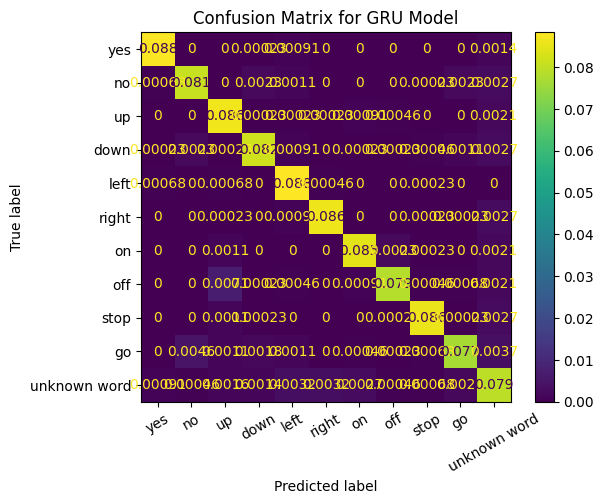

In [ ]:
confusion_matrix(model_gru, test_loader, "GRU Model")

### Entrenamiento del Modelo Elman RNN (Ventana de 40 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves = []
rnn_times = []

for train_run in range(n_trains):
    model_rnn = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves.append(curves)
    rnn_times.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times):.2f} +- {np.std(rnn_times):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

{'train_acc': 0.2062058977598373,
 'train_loss': 2.1017058367604737,
 'val_acc': 0.18787096774193549,
 'val_loss': 2.1510439678930466}

Early stopping.

Tiempo total de entrenamiento: 295.6012 [s]
Tiempo de entrenamiento promedio de 1 corridas: 295.60 +- 0.00 [s]


Graficamos los resultados del entrenamiento

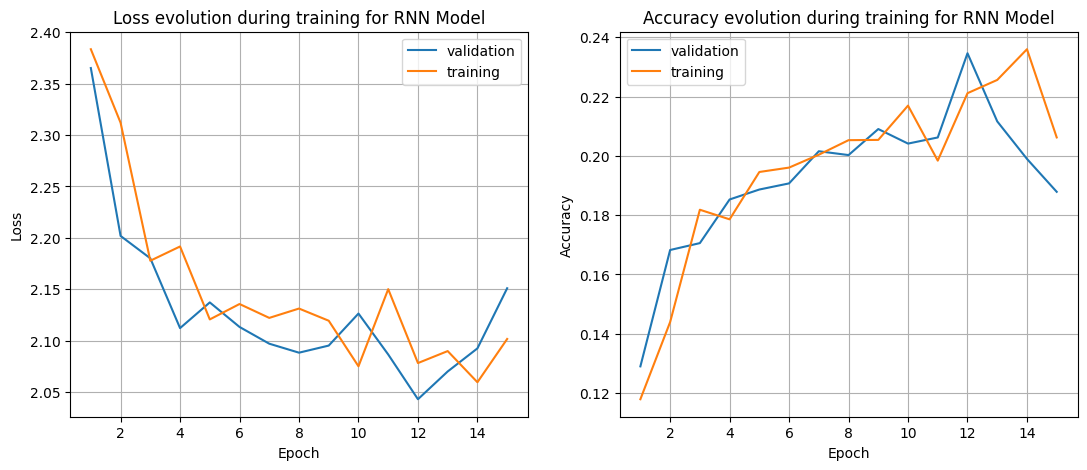

In [ ]:
show_curves(rnn_all_curves, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

RNN Model metrics

Accuracy: 19.72%
Precision: 21.99%
Recall: 19.66%
F1-score: 16.95%


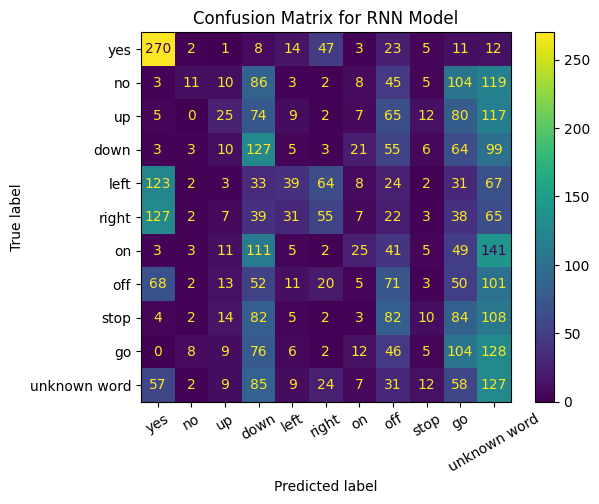

In [ ]:
confusion_matrix(model_rnn, test_loader, "RNN Model")

### Entrenamiento del Modelo Elman RNN (Ventana de 80 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves_80 = []
rnn_times_80 = []

for train_run in range(n_trains):
    model_rnn_80 = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn_80,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves_80.append(curves)
    rnn_times_80.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times_80):.2f} +- {np.std(rnn_times_80):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]


Tiempo total de entrenamiento: 347.4747 [s]
Tiempo de entrenamiento promedio de 1 corridas: 347.47 +- 0.00 [s]


Graficamos los resultados del entrenamiento

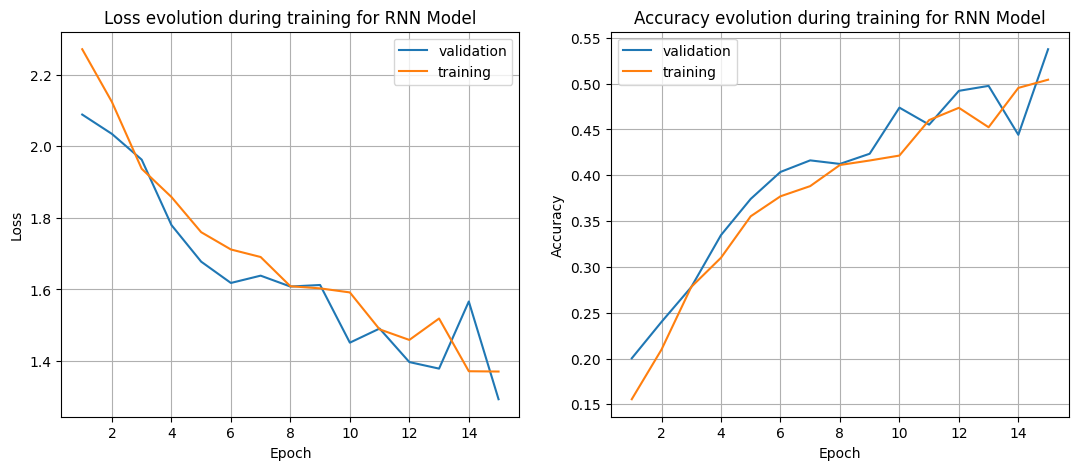

In [ ]:
show_curves(rnn_all_curves_80, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

RNN Model metrics

Accuracy: 53.00%
Precision: 52.22%
Recall: 53.19%
F1-score: 51.98%


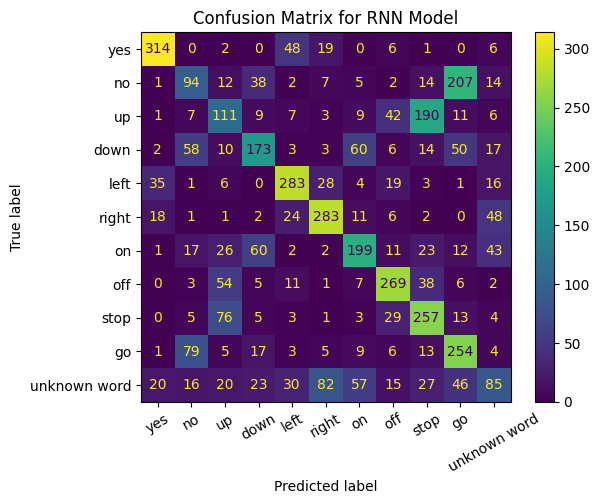

In [ ]:
confusion_matrix(model_rnn_80, test_loader, "RNN Model")

RNN Model metrics

Accuracy: 54.01%
Precision: 52.74%
Recall: 54.25%
F1-score: 52.56%


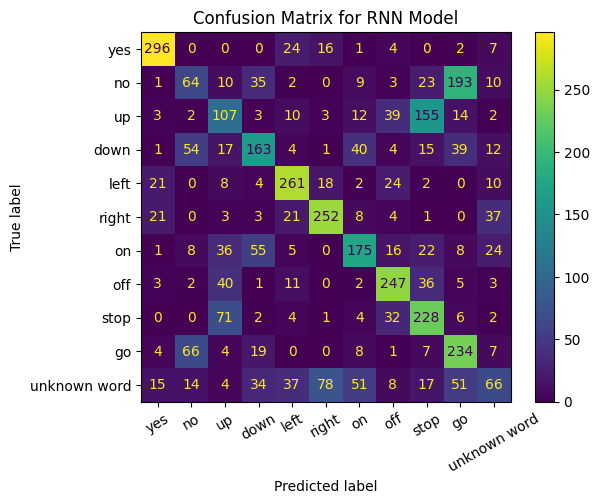

In [ ]:
confusion_matrix(model_rnn_80, val_loader, "RNN Model")

### Entrenamiento del Modelo Elman RNN (Ventana de 120 ms)

In [ ]:
lr = 1e-3
batch_size = 64
criterion = nn.CrossEntropyLoss()
n_trains = 1
epochs = 15

hidden_size = 256
num_layers = 1

rnn_all_curves_120 = []
rnn_times_120 = []

for train_run in range(n_trains):
    model_rnn_120 = RNNModel(N_MFCC * 3, hidden_size, num_layers) # MFCC, Delta, DeltaDelta

    curves, total_time = train_model(
        model_rnn_120,
        epochs,
        criterion,
        batch_size,
        lr,
        use_gpu=True,
    )

    rnn_all_curves_120.append(curves)
    rnn_times_120.append(total_time)

print(f"Tiempo de entrenamiento promedio de {n_trains} corridas: {np.mean(rnn_times_120):.2f} +- {np.std(rnn_times_120):.2f} [s]")

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]

  0%|          | 0/254 [00:00<?, ?it/s]


Tiempo total de entrenamiento: 342.6586 [s]
Tiempo de entrenamiento promedio de 1 corridas: 342.66 +- 0.00 [s]


Graficamos los resultados del entrenamiento

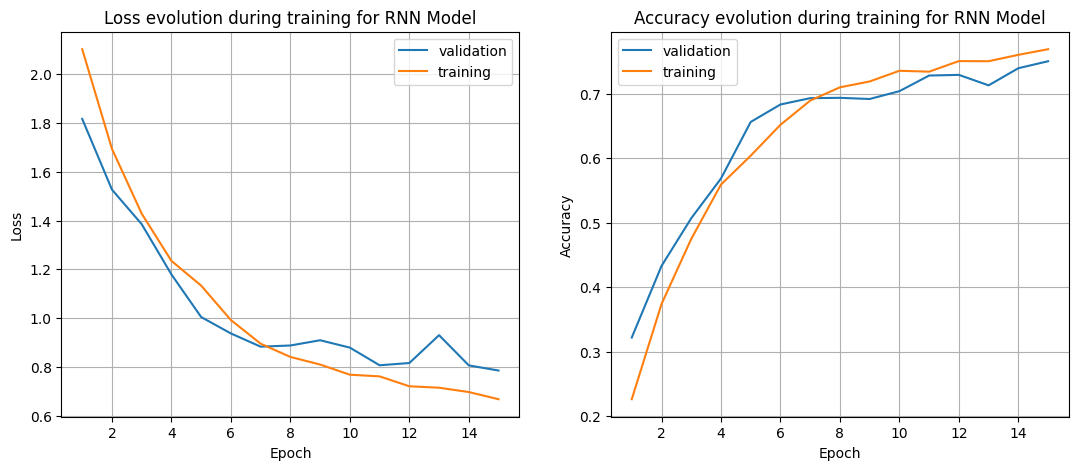

In [ ]:
show_curves(rnn_all_curves_120, "RNN Model")

Graficamos la matriz de confusión y obtenemos las métricas

RNN Model metrics

Accuracy: 73.77%
Precision: 73.37%
Recall: 73.93%
F1-score: 72.63%


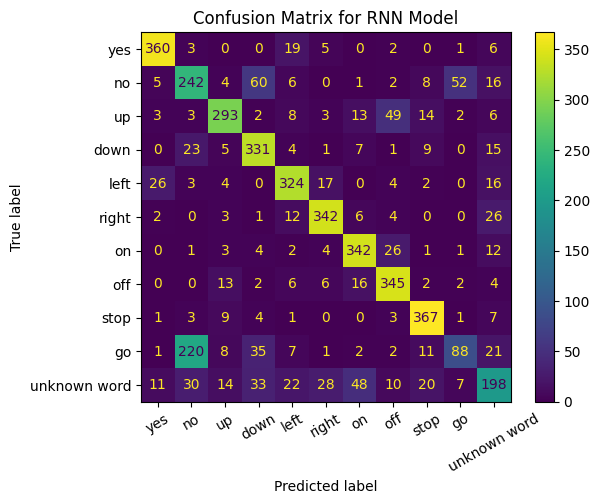

In [ ]:
confusion_matrix(model_rnn_120, test_loader, "RNN Model")

RNN Model metrics

Accuracy: 75.23%
Precision: 75.42%
Recall: 75.38%
F1-score: 74.08%


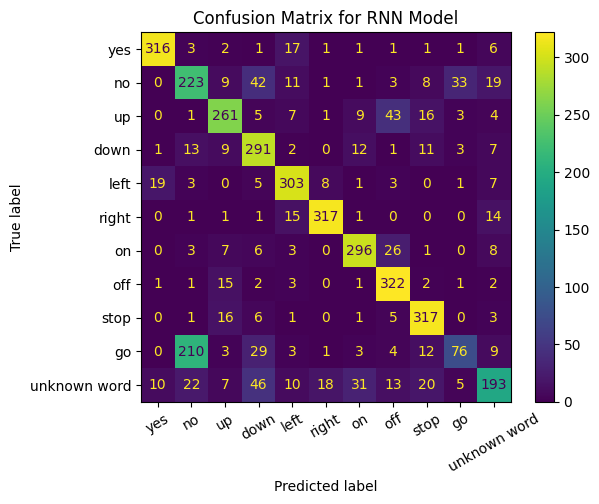

In [ ]:
confusion_matrix(model_rnn_120, val_loader, "RNN Model")

# EXPORT


In [ ]:
max_len = max(len(lstm_all_curves[0]["val_acc"]), len(gru_all_curves[0]["val_acc"]), len(rnn_all_curves[0]["val_acc"]), len(rnn_all_curves_80[0]["val_acc"]),len(rnn_all_curves_120[0]["val_acc"]))

all_val_loss = [lstm_all_curves[0]["val_acc"], gru_all_curves[0]["val_acc"], rnn_all_curves[0]["val_acc"], rnn_all_curves_80[0]["val_acc"],rnn_all_curves_120[0]["val_acc"]]

for vloss in all_val_loss:

    if len(vloss) == max_len:
        continue

    ll = len(vloss)
    for _ in range(max_len-ll):
        vloss.append(vloss[-1])

vl = np.array(all_val_loss)



In [ ]:
np.savetxt("data3.csv", vl,
              delimiter = ",")

# WandB

In [ ]:
!pip install wandb -qU
import wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 17.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 21.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.9/243.9 kB 17.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
# Aquí hay que poner la llave de WandB
wandb.login()

wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

### **Comparación Inicial:** Variación de Hiperparámetros base entre los modelos

#### Función de entrenamiento

In [ ]:
def train_model_wandb(
    config,
    model,
    use_gpu=True,
    epoch_tolerance=3,
    test_dloader=test_loader
):

    with wandb.init(config=config):

        config = wandb.config
        model = model(N_MFCC * 3, config.hidden_size, config.num_layers)

        early_stopped = False

        if use_gpu:
            model.cuda()

        # Optimizador
        if config.optim == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=config.lr, betas=(0.9, 0.98), eps=1e-9)
        elif config.optim == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=config.lr, eps=1e-9)
        else:
            raise ValueError(f"chosen optimizer is not valid {config.optim}.")

        # Criterion
        if config.criterion == "cross_entropy":
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError(f"chosen criterion is not valid {config.criterion}.")

        # t0 = time.perf_counter()

        iteration = 0

        n_batches = len(train_loader)
        early_stopping = EarlyStopping(epoch_tolerance)

        post = {
            "val/val_loss": 0,
            "val/val_acc": 0,
            "train/train_loss": 0,
            "train/train_acc": 0,
            "train/epoch": 0
        }

        num_of_batches = len(train_loader)

        for epoch in range(config.epochs):
            st = time.time()
            cumulative_train_loss = 0
            cumulative_train_corrects = 0
            examples_count = 0

            # description = f"Running Epoch {epoch+1}"

            # my_pbar = tqdm(train_loader, leave=False)
            # my_pbar.set_description(description)

            # Entrenamiento del modelo
            model.train()
            count = 0
            for x_batch, y_batch in train_loader:
                if use_gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                # my_pbar.set_postfix(post)

                y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

                cumulative_train_loss += loss.item() * x_batch.shape[0]
                examples_count += y_batch.shape[0]

                # Calculamos número de aciertos
                class_prediction = torch.argmax(y_predicted, axis=1).long()

                cumulative_train_corrects += (y_batch == class_prediction).sum().item()

                count += 1
                print(f"\rEpoch {epoch + 1} - {count / num_of_batches * 100:.2f}% done", end="")

            model.eval()
            with torch.no_grad():
                val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

            train_loss = cumulative_train_loss / examples_count
            train_acc = cumulative_train_corrects / examples_count

            post["val/val_loss"] = val_loss
            post["val/val_acc"] = val_acc
            post["train/train_acc"] = train_acc
            post["train/train_loss"] = train_loss
            post["train/epoch"] = epoch + 1

            wandb.log(post)
            # Early Stopping

            if early_stopping(val_loss):
                early_stopped = True
                # pprint(post)
                print("\nEarly stopping.")
                break

        model.cpu()
        model.eval()

        y_true = []
        y_pred = []
        y_true_conf = []
        y_pred_conf = []
        for x, y in test_dloader:
            y_true.append(y)
            y_true_conf += y.tolist()

            pred = model(x).argmax(dim=1)

            y_pred.append(pred)
            y_pred_conf += pred.tolist()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        test_metrics = {
            "test/accuracy": accuracy_score(y_true, y_pred),
            "test/precision": precision_score(y_true, y_pred, average='macro'),
            "test/recall": recall_score(y_true, y_pred, average='macro'),
            "test/f1_score": f1_score(y_true, y_pred, average='macro')
        }

        # total_time = time.perf_counter() - t0
        wandb.run.summary["Early Stopped"] = early_stopped
        wandb.run.summary["Model Name"] = str(model)
        # wandb.run.summary["Training Time/Seconds"] = total_time,

        for key, value in test_metrics.items():
            wandb.run.summary[key] = value

        wandb.log({"test/conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true_conf, preds=y_pred_conf,
                        class_names=VALID_LABELS)})

    return None

#### Entrenamiento y evaluación de los modelos

In [ ]:
# Modelos a entrenar
models_to_train = [RNNModel, GRUModel] #, LSTMModel]

parameters_dict = {
            "epochs": {
                "value": 15
                },
            "criterion": {
                "value": "cross_entropy"
                },
            "optim": {
                "values": ["adam", "rmsprop"]
                },
            "lr": {
                "values": [1e-3, 1e-2, 1e-4]
                },
            "hidden_size": {
                "values": [256, 512, 128]
                },
            "num_layers": {
                "value": 1
                },
            "directionality": {
                "value": "uni"
                }
            }

sweep_config = {
    'method': 'grid'
    }

sweep_config['parameters'] = parameters_dict

for model in models_to_train:

    sweep_id = wandb.sweep(sweep_config, project=f"{model.__name__}")

    def train_aux(config=None, model=model):
        return train_model_wandb(config, model)

    wandb.agent(sweep_id, train_aux)

Create sweep with ID: 16n42n9l
Sweep URL: https://wandb.ai/5g-research/RNNModel/sweeps/16n42n9l


wandb: Agent Starting Run: gdyfa6mb with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam
wandb: Currently logged in as: agustin-gonzalez (5g-research). Use `wandb login --relogin` to force relogin


Epoch 9 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▃▅▇▇▇█▄▄
train/train_loss,█▆▅▂▁▂▁▆▅
val/val_acc,▂▄▄▆▄█▁▃▄
val/val_loss,▆▅▂▂▃▁█▆▅
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.18968
test/f1_score,0.16859
test/precision,0.22235
test/recall,0.19047


wandb: Agent Starting Run: ekm3odb5 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 8 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▆▇█
train/train_acc,▁▂▅▆▇▅██
train/train_loss,█▇▅▃▁▅▂▁
val/val_acc,▁▂▇██▇█▅
val/val_loss,██▂▂▁▆▁▅
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.15111
test/f1_score,0.14393
test/precision,0.22113
test/recall,0.15042


wandb: Agent Starting Run: h5z77sgi with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 7 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train/epoch,▁▂▃▅▆▇█
train/train_acc,▁▃▄▅▆██
train/train_loss,█▇▄▁▄▁▂
val/val_acc,▁▅▃▃▆▇█
val/val_loss,█▄▄▁▄▂█
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.1123
test/f1_score,0.05348
test/precision,0.07038
test/recall,0.1121


wandb: Agent Starting Run: c12g9gor with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 4 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train/epoch,▁▃▆█
train/train_acc,▁▃██
train/train_loss,█▂▁▁
val/val_acc,▆▂▁█
val/val_loss,▁█▅▂
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.09975
test/f1_score,0.06108
test/precision,0.12088
test/recall,0.09915


wandb: Agent Starting Run: vxdzuld4 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▃▄▄▆▇▇▇▇▇█▇██
train/train_loss,█▇▇▇▆▄▃▃▂▂▁▂▁▁▁
val/val_acc,▁▃▄▄▅▇▅▆▇▇█▇█▆█
val/val_loss,██▇▇▅▃▃▂▂▂▂▂▁▂▁
Early Stopped,False
Model Name,RNNModel
test/accuracy,0.21137
test/f1_score,0.176
test/precision,0.20108
test/recall,0.21229


wandb: Agent Starting Run: wiects9v with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▃▃▃▄▅▅▆▇▇▇▇██
train/train_loss,██▇▇▇▆▅▄▄▃▂▃▂▂▁
val/val_acc,▁▂▂▃▄▃▄▆▆▇▇███▆
val/val_loss,██▇▇▇▆▄▃▃▂▂▂▂▁▁
Early Stopped,False
Model Name,RNNModel
test/accuracy,0.24013
test/f1_score,0.2206
test/precision,0.23724
test/recall,0.24033


wandb: Agent Starting Run: mf79vp5w with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done
Early stopping.


train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▄▃▅▅▅▅▆▆▇▇▇▆█
train/train_loss,█▇▄▆▃▃▃▄▃▂▂▂▁▃▁
val/val_acc,▁▁▂▄▃▆▂▇▆▄▅▇▆▆█
val/val_loss,█▇▇▄▃▃▄▃▃▃▄▁▂▂▁
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.24264
test/f1_score,0.21638
test/precision,0.2443
test/recall,0.24265


wandb: Agent Starting Run: dn8p646a with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 6 - 100.00% done
Early stopping.


train/epoch,▁▂▄▅▇█
train/train_acc,▁▂▄██▆
train/train_loss,█▆▅▁▁▃
val/val_acc,▁▃█▂▄▁
val/val_loss,▆▇▁▇▅█
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.11367
test/f1_score,0.06798
test/precision,0.20891
test/recall,0.1143


wandb: Agent Starting Run: xfs74uc9 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 9 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▄▅▅▅▄▅▅█
train/train_loss,█▂▄▁▁▃▃▂▃
val/val_acc,▃▁█▅▅█▅▆▄
val/val_loss,▄█▁▁▄▁▅▅▆
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.11322
test/f1_score,0.05309
test/precision,0.14658
test/recall,0.11387


wandb: Agent Starting Run: a7w4p0dy with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 6 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train/epoch,▁▂▄▅▇█
train/train_acc,▁▁▄▄▇█
train/train_loss,█▂▃▂▂▁
val/val_acc,▁▃▅▃█▄
val/val_loss,▆█▁▄▄▂
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.10751
test/f1_score,0.05057
test/precision,0.09043
test/recall,0.1081


wandb: Agent Starting Run: ixaskg0r with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▃▅▅▅▅▆▆▆▆▇▇▇█
train/train_loss,█▇▇▅▄▄▃▃▃▃▃▂▂▂▁
val/val_acc,▁▃▃▄▅▇▅▄▅▆▇▅▆█▇
val/val_loss,██▅▅▄▄▄▄▃▃▃▃▂▂▁
Early Stopped,False
Model Name,RNNModel
test/accuracy,0.25633
test/f1_score,0.25347
test/precision,0.27392
test/recall,0.25704


wandb: Agent Starting Run: ebhv85r1 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▃▄▄▅▅▆▆▆▇▇███
train/train_loss,█▇▇▆▅▄▃▃▃▃▂▁▂▁▁
val/val_acc,▁▂▃▄▄▅▆▆▆▄▇▅██▅
val/val_loss,█▇▅▄▄▄▃▃▃▆▂▂▂▁▃
Early Stopped,False
Model Name,RNNModel
test/accuracy,0.19493
test/f1_score,0.16199
test/precision,0.21046
test/recall,0.1959


wandb: Agent Starting Run: rh7s6255 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 10 - 100.00% done
Early stopping.


train/epoch,▁▂▃▃▄▅▆▆▇█
train/train_acc,▁▃▃▄▄▅▇▇██
train/train_loss,█▇▇▅▅▄▂▂▂▁
val/val_acc,▁▂▂▅▂▇█▇▇█
val/val_loss,█▇█▄█▁▁▁▂▁
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.22027
test/f1_score,0.16964
test/precision,0.20251
test/recall,0.22122


wandb: Agent Starting Run: 2yrmri38 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 12 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▄▄▅▅▆▇▇█
train/train_acc,▁▂▃▄▆▆▇▇▇███
train/train_loss,█▇▇▅▃▃▂▂▂▁▂▁
val/val_acc,▁▂▄▆▆▆▆█▇▆▇▅
val/val_loss,█▇▅▃▂▂▁▂▁▁▄▄
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.17781
test/f1_score,0.15107
test/precision,0.19191
test/recall,0.17817


wandb: Agent Starting Run: m8bhe1lx with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 7 - 100.00% done
Early stopping.


train/epoch,▁▂▃▅▆▇█
train/train_acc,▁▅▇▆▆█▇
train/train_loss,█▃▅▅▃▁▂
val/val_acc,▄▁▆█▅▄▄
val/val_loss,▃▇█▁▅▄▁
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.12098
test/f1_score,0.08083
test/precision,0.14555
test/recall,0.12148


wandb: Agent Starting Run: y53lvor2 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 6 - 100.00% done
Early stopping.


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


train/epoch,▁▂▄▅▇█
train/train_acc,▁▁▄▄▅█
train/train_loss,█▂▂▂▁▁
val/val_acc,▁▂▅▁▇█
val/val_loss,▅▄▁█▅▄
Early Stopped,True
Model Name,RNNModel
test/accuracy,0.1123
test/f1_score,0.06932
test/precision,0.25508
test/recall,0.11293


wandb: Agent Starting Run: z2yvjqca with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▃▃▃▄▄▅▅▆▇▇███
train/train_loss,█▇▇▇▇▆▆▆▆▅▄▃▂▂▁
val/val_acc,▁▁▁▂▂▂▃▃▄▆▇▇▇▇█
val/val_loss,███▇▇▇▇▆▆▄▄▃▂▂▁
Early Stopped,False
Model Name,RNNModel
test/accuracy,0.18557
test/f1_score,0.15841
test/precision,0.17434
test/recall,0.18645


wandb: Agent Starting Run: v2u5q4vo with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▃▃▃▄▄▅▅▅▆▆▆▇█
train/train_loss,█▇▇▇▆▆▆▅▅▅▅▄▄▂▁
val/val_acc,▁▁▁▁▂▄▃▂▃▄▄▅▄▅█
val/val_loss,███▇▇▇▇▆▆▆▅▅▄▂▁
Early Stopped,False
Model Name,RNNModel
test/accuracy,0.16389
test/f1_score,0.14294
test/precision,0.16052
test/recall,0.1642


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


Create sweep with ID: 2zptzpv5
Sweep URL: https://wandb.ai/5g-research/GRUModel/sweeps/2zptzpv5


wandb: Agent Starting Run: uthvwafm with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 7 - 100.00% done
Early stopping.


train/epoch,▁▂▃▅▆▇█
train/train_acc,▁▆▇▇███
train/train_loss,█▃▂▂▁▁▁
val/val_acc,▁▄▇████
val/val_loss,█▄▂▁▁▂▁
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.91806
test/f1_score,0.9188
test/precision,0.92038
test/recall,0.91854


wandb: Agent Starting Run: wcmbeq2u with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 7 - 100.00% done
Early stopping.


train/epoch,▁▂▃▅▆▇█
train/train_acc,▁▆▇▇▇██
train/train_loss,█▃▂▂▁▁▁
val/val_acc,▁▄▅▇▆▆█
val/val_loss,█▄▃▁▂▂▁
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.9176
test/f1_score,0.91865
test/precision,0.92082
test/recall,0.91803


wandb: Agent Starting Run: 0emt7hfc with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 7 - 100.00% done
Early stopping.


train/epoch,▁▂▃▅▆▇█
train/train_acc,▁▅▆▆▇▇█
train/train_loss,█▄▃▃▂▂▁
val/val_acc,▁▁▇█▂▄▅
val/val_loss,█▇▂▁█▄▄
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.8304
test/f1_score,0.83221
test/precision,0.83537
test/recall,0.83146


wandb: Agent Starting Run: jm5pq7hj with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 9 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▆▇▇█████
train/train_loss,█▂▂▂▁▁▁▁▁
val/val_acc,▂▄▅▁▆█▆▃█
val/val_loss,▅▅▃█▂▁▄▅▂
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.83155
test/f1_score,0.8325
test/precision,0.83738
test/recall,0.83279


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: k54nhe9j with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▄▅▆▇▇▇▇▇██████
train/train_loss,█▆▄▃▃▂▂▂▂▁▁▁▁▁▁
val/val_acc,▁▄▅▆▇▇▇▇███████
val/val_loss,█▆▄▃▂▂▂▂▁▁▁▁▁▁▁
Early Stopped,False
Model Name,GRUModel
test/accuracy,0.89979
test/f1_score,0.90028
test/precision,0.90094
test/recall,0.90058


wandb: Agent Starting Run: xfuhcd5q with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 256
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▄▅▆▇▇▇▇▇██████
train/train_loss,█▅▄▃▂▂▂▂▂▁▁▁▁▁▁
val/val_acc,▁▄▅▆▇▇▇▇▇██████
val/val_loss,█▅▄▃▂▂▂▂▁▁▁▁▁▁▁
Early Stopped,False
Model Name,GRUModel
test/accuracy,0.90756
test/f1_score,0.9075
test/precision,0.90759
test/recall,0.90835


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: dbme9nys with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 6 - 100.00% done
Early stopping.


train/epoch,▁▂▄▅▇█
train/train_acc,▁▆▇███
train/train_loss,█▃▂▁▁▁
val/val_acc,▁▆▆█▇▇
val/val_loss,█▃▁▁▃▂
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.92833
test/f1_score,0.9287
test/precision,0.9289
test/recall,0.92891


wandb: Agent Starting Run: 2tdgu85y with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 9 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▆▇▇▇████
train/train_loss,█▃▂▂▂▁▁▁▁
val/val_acc,▁▆▆▂▇█▇▇▇
val/val_loss,█▃▂▇▁▁▂▁▃
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.92582
test/f1_score,0.92706
test/precision,0.9296
test/recall,0.92606


wandb: Agent Starting Run: 3f21s1u2 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 11 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▄▅▅▆▇▇█
train/train_acc,▁▅▆▆▆▆▇▇███
train/train_loss,█▄▃▃▂▂▂▂▂▁▁
val/val_acc,▁▃▁▆▅▆▆█▇█▆
val/val_loss,▆▄█▄▄▅▃▁▃▃▆
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.8304
test/f1_score,0.82946
test/precision,0.8406
test/recall,0.8322


wandb: Agent Starting Run: yv9dh65z with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 9 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▅▆▇▇▇███
train/train_loss,█▂▂▂▁▁▁▁▁
val/val_acc,▁▃▆▇▅█▅▇▄
val/val_loss,▅█▂▂▄▁▄▃▅
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.71513
test/f1_score,0.70768
test/precision,0.80655
test/recall,0.71496


wandb: Agent Starting Run: ym0ie5th with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▅▆▇▇▇▇████████
train/train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val/val_acc,▁▅▆▇▇██████████
val/val_loss,█▄▂▂▂▁▁▁▁▁▁▁▁▁▁
Early Stopped,False
Model Name,GRUModel
test/accuracy,0.92582
test/f1_score,0.92642
test/precision,0.92696
test/recall,0.92637


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: r5qfwcun with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 512
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 13 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train/train_acc,▁▅▆▆▇▇▇██████
train/train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁
val/val_acc,▁▅▆▇▇▇█▇█████
val/val_loss,█▄▃▂▂▁▁▁▁▁▁▁▁
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.91965
test/f1_score,0.92022
test/precision,0.92186
test/recall,0.92031


wandb: Agent Starting Run: 6tw57vk1 with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 13 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train/train_acc,▁▆▇▇▇▇███████
train/train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁
val/val_acc,▁▅▆▇▇▇▇█▇████
val/val_loss,█▃▂▂▂▁▁▁▁▁▁▁▁
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.9087
test/f1_score,0.9096
test/precision,0.91193
test/recall,0.90907


wandb: Agent Starting Run: 3hgej0rm with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 12 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▄▄▅▅▆▇▇█
train/train_acc,▁▅▆▇▇▇▇█████
train/train_loss,█▄▃▂▂▂▂▁▁▁▁▁
val/val_acc,▁▅▅▆▇▇▇███▆▅
val/val_loss,█▄▃▂▂▂▂▁▁▁▃▄
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.88519
test/f1_score,0.88689
test/precision,0.89751
test/recall,0.88573


wandb: Agent Starting Run: qhfdyz8d with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 10 - 100.00% done
Early stopping.


train/epoch,▁▂▃▃▄▅▆▆▇█
train/train_acc,▁▆▆▇▇▇████
train/train_loss,█▃▂▂▂▂▁▁▁▁
val/val_acc,▁▃▄▅▅▇██▅▆
val/val_loss,█▅▄▄▄▃▁▂▃▂
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.82926
test/f1_score,0.83195
test/precision,0.83676
test/recall,0.83006


wandb: Agent Starting Run: 5u9mms0o with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.01
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 8 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▆▇█
train/train_acc,▁▆▇▇████
train/train_loss,█▃▂▂▁▁▁▁
val/val_acc,▁▂▅▄█▅▇▇
val/val_loss,█▆▄▅▁▄▁▂
Early Stopped,True
Model Name,GRUModel
test/accuracy,0.80735
test/f1_score,0.81224
test/precision,0.82696
test/recall,0.80785


wandb: Agent Starting Run: cfupvk7c with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: adam


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▃▅▆▆▇▇▇▇▇█████
train/train_loss,█▇▆▅▄▃▃▂▂▂▂▁▁▁▁
val/val_acc,▁▃▅▅▆▆▇▇▇▇█████
val/val_loss,█▇▅▄▄▃▃▂▂▂▁▁▁▁▁
Early Stopped,False
Model Name,GRUModel
test/accuracy,0.83839
test/f1_score,0.83795
test/precision,0.83767
test/recall,0.83984


wandb: Agent Starting Run: qftbo6xd with config:
wandb: 	criterion: cross_entropy
wandb: 	directionality: uni
wandb: 	epochs: 15
wandb: 	hidden_size: 128
wandb: 	lr: 0.0001
wandb: 	num_layers: 1
wandb: 	optim: rmsprop


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▄▅▆▆▇▇▇▇▇█████
train/train_loss,█▇▅▄▃▃▂▂▂▂▁▁▁▁▁
val/val_acc,▁▃▅▅▆▆▇▇▇▇█████
val/val_loss,█▆▅▄▃▃▂▂▂▂▁▁▁▁▁
Early Stopped,False
Model Name,GRUModel
test/accuracy,0.85734
test/f1_score,0.85777
test/precision,0.85809
test/recall,0.85867


wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


#### Resultados

Se encontró que para los distintos modelos los mejores parámetros son:

**GRUModel**:

_test accuracy: 0.9283_
- hidden_size: 512
- lr: 0.001
- optim: adam

**LSTMModel**:

_test accuracy: 0.9162_
- hidden_size: 256
- lr: 0.001
- optim: "adam"

**RNNModel**:

_test accuracy: 0.2563_
- hidden_size: 512
- lr: 0.0001
- optim: "adam"

### **Comparación Intermedia:** Variación de **rellenar**

#### Función de entrenamiento

In [ ]:
optim_values = {
    "rnnmodel": {
        "lr": 0.0001,
        "hidden_size": 512,
        "optimizer": "adam",
    },
    "lstmmodel": {
        "lr": 0.001,
        "hidden_size": 256,
        "optimizer": "adam",
    },
    "grumodel": {
        "lr": 0.001,
        "hidden_size": 512,
        "optimizer": "adam",
    }
}

In [ ]:
def train_model_wandb_exp2(
    config=None,
    use_gpu=True,
    epoch_tolerance=3,
    test_dloader=test_loader
):

    with wandb.init(config=config):

        config = wandb.config

        model_hyperp = optim_values[config.model]

        if config.model.lower() == "grumodel":
            model = GRUModel(N_MFCC * 3, model_hyperp["hidden_size"], config.num_layers, bidirectional=config.bidirectional)
        elif config.model.lower() == "lstmmodel":
            model = LSTMModel(N_MFCC * 3, model_hyperp["hidden_size"], config.num_layers, bidirectional=config.bidirectional)
        elif config.model.lower() == "rnnmodel":
            model = RNNModel(N_MFCC * 3, model_hyperp["hidden_size"], config.num_layers, bidirectional=config.bidirectional)
        else:
            raise ValueError(f"chosen model is not valid {config.model}.")

        early_stopped = False

        if use_gpu:
            model.cuda()

        # Optimizador
        if model_hyperp["optimizer"] == "rmsprop":
            optimizer = torch.optim.RMSprop(model.parameters(), lr=model_hyperp["lr"], eps=1e-9)
        elif model_hyperp["optimizer"] == "adam":
            optimizer = torch.optim.Adam(model.parameters(), lr=model_hyperp["lr"], betas=(0.9, 0.98), eps=1e-9)
        else:
            raise ValueError(f"chosen optimizer is not valid {config.optim}.")


        # Criterion
        if config.criterion == "cross_entropy":
            criterion = nn.CrossEntropyLoss()
        else:
            raise ValueError(f"chosen criterion is not valid {config.criterion}.")

        # t0 = time.perf_counter()

        iteration = 0

        n_batches = len(train_loader)
        early_stopping = EarlyStopping(epoch_tolerance)

        post = {
            "val/val_loss": 0,
            "val/val_acc": 0,
            "train/train_loss": 0,
            "train/train_acc": 0,
            "train/epoch": 0
        }

        num_of_batches = len(train_loader)

        for epoch in range(config.epochs):
            st = time.time()
            cumulative_train_loss = 0
            cumulative_train_corrects = 0
            examples_count = 0

            # description = f"Running Epoch {epoch+1}"

            # my_pbar = tqdm(train_loader, leave=False)
            # my_pbar.set_description(description)

            # Entrenamiento del modelo
            model.train()
            count = 0
            for x_batch, y_batch in train_loader:
                if use_gpu:
                    x_batch = x_batch.cuda()
                    y_batch = y_batch.cuda()

                # my_pbar.set_postfix(post)

                y_predicted, loss = train_step(x_batch, y_batch, model, optimizer, criterion, use_gpu)

                cumulative_train_loss += loss.item() * x_batch.shape[0]
                examples_count += y_batch.shape[0]

                # Calculamos número de aciertos
                class_prediction = torch.argmax(y_predicted, axis=1).long()

                cumulative_train_corrects += (y_batch == class_prediction).sum().item()

                count += 1
                print(f"\rEpoch {epoch + 1} - {count / num_of_batches * 100:.2f}% done", end="")

            model.eval()
            with torch.no_grad():
                val_acc, val_loss = evaluate(val_loader, model, criterion, use_gpu)

            train_loss = cumulative_train_loss / examples_count
            train_acc = cumulative_train_corrects / examples_count

            post["val/val_loss"] = val_loss
            post["val/val_acc"] = val_acc
            post["train/train_acc"] = train_acc
            post["train/train_loss"] = train_loss
            post["train/epoch"] = epoch + 1

            wandb.log(post)
            # Early Stopping

            if early_stopping(val_loss):
                early_stopped = True
                print("\nEarly stopping.")
                break

        model.cpu()
        model.eval()

        y_true = []
        y_pred = []
        y_true_conf = []
        y_pred_conf = []
        for x, y in test_dloader:
            y_true.append(y)
            y_true_conf += y.tolist()

            pred = model(x).argmax(dim=1)

            y_pred.append(pred)
            y_pred_conf += pred.tolist()

        y_true = torch.cat(y_true)
        y_pred = torch.cat(y_pred)

        test_metrics = {
            "test/accuracy": accuracy_score(y_true, y_pred),
            "test/precision": precision_score(y_true, y_pred, average='macro'),
            "test/recall": recall_score(y_true, y_pred, average='macro'),
            "test/f1_score": f1_score(y_true, y_pred, average='macro')
        }

        # total_time = time.perf_counter() - t0
        wandb.run.summary["Early Stopped"] = early_stopped
        wandb.run.summary["Model Name"] = str(model)
        # wandb.run.summary["Training Time/Seconds"] = total_time,

        for key, value in test_metrics.items():
            wandb.run.summary[key] = value

        for key, value in model_hyperp.items():
            wandb.run.summary[key] = value

        wandb.log({"test/conf_mat" : wandb.plot.confusion_matrix(probs=None,
                        y_true=y_true_conf, preds=y_pred_conf,
                        class_names=VALID_LABELS)})

    return None

#### Entrenamiento y evaluación de los modelos

In [ ]:
# Modelos a entrenar
models_to_train = []#[LSTMModel, RNNModel, GRUModel]

parameters_dict = {
            "epochs": {
                "value": 15
                },
            "criterion": {
                "value": "cross_entropy"
                },
            "model": {
                "values": ["grumodel", "lstmmodel", "rnnmodel"]
                },
            "num_layers": {
                "values": [1, 2, 3, 4]
                },
            "bidirectional": {
                "values": [True, False]
                }
            }

sweep_config = {
    'method': 'grid'
    }

sweep_config['parameters'] = parameters_dict

# sweep_id = wandb.sweep(sweep_config, project="Best HyperP Comparison")
sweep_id = "emwfhacd"

wandb.agent(sweep_id, train_model_wandb_exp2)

Create sweep with ID: emwfhacd
Sweep URL: https://wandb.ai/5g-research/Best%20HyperP%20Comparison/sweeps/emwfhacd


wandb: Agent Starting Run: mmj2zje6 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 1


Epoch 9 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▆▇▇▇████
train/train_loss,█▃▂▂▂▁▁▁▁
val/val_acc,▁▇▇▇▇▇█▇█
val/val_loss,█▂▂▁▂▁▁▂▃
Early Stopped,True
Model Name,GRUModel
hidden_size,512
lr,0.001
optimizer,adam
test/accuracy,0.9281


wandb: Agent Starting Run: h650jeou with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 2


Epoch 8 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▆▇█
train/train_acc,▁▆▇▇▇███
train/train_loss,█▃▂▂▂▁▁▁
val/val_acc,▁▅▅▇█▇▇█
val/val_loss,█▃▃▂▁▂▃▂
Early Stopped,True
Model Name,GRUModel
hidden_size,512
lr,0.001
optimizer,adam
test/accuracy,0.93472


wandb: Agent Starting Run: hosfzbz1 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 3


Epoch 9 - 100.00% done
Early stopping.


train/epoch,▁▂▃▄▅▅▆▇█
train/train_acc,▁▆▇▇█████
train/train_loss,█▃▂▂▂▁▁▁▁
val/val_acc,▁▆▇▆▅█▆▇█
val/val_loss,█▂▁▃▃▁▄▂▁
Early Stopped,True
Model Name,GRUModel
hidden_size,512
lr,0.001
optimizer,adam
test/accuracy,0.93654


wandb: Agent Starting Run: s8xime6s with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: grumodel
wandb: 	num_layers: 4


Epoch 6 - 100.00% done
Early stopping.


train/epoch,▁▂▄▅▇█
train/train_acc,▁▆▇▇██
train/train_loss,█▃▂▂▁▁
val/val_acc,▁▄█▆██
val/val_loss,█▆▁▅▁▂
Early Stopped,True
Model Name,GRUModel
hidden_size,512
lr,0.001
optimizer,adam
test/accuracy,0.93814


wandb: Agent Starting Run: 5rd95wjp with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 1


Epoch 13 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train/train_acc,▁▆▇▇▇▇███████
train/train_loss,█▃▂▂▂▂▁▁▁▁▁▁▁
val/val_acc,▁▅▆▇█▇▇██████
val/val_loss,█▄▃▂▂▂▂▁▁▁▁▁▁
Early Stopped,True
Model Name,LSTMModel
hidden_size,256
lr,0.001
optimizer,adam
test/accuracy,0.9192


wandb: Agent Starting Run: ouro54g3 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 2


Epoch 11 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▄▅▅▆▇▇█
train/train_acc,▁▆▆▇▇▇█████
train/train_loss,█▄▃▂▂▂▁▁▁▁▁
val/val_acc,▁▄▇▇▇▇███▇█
val/val_loss,█▄▂▂▂▂▁▁▁▂▂
Early Stopped,True
Model Name,LSTMModel
hidden_size,256
lr,0.001
optimizer,adam
test/accuracy,0.92331


wandb: Agent Starting Run: zq39qg5j with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 3


Epoch 12 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▄▄▅▅▆▇▇█
train/train_acc,▁▅▆▇▇▇██████
train/train_loss,█▄▃▂▂▂▂▁▁▁▁▁
val/val_acc,▁▄▄▆▆▇▇▇██▇█
val/val_loss,█▅▄▃▂▂▁▂▁▁▂▂
Early Stopped,True
Model Name,LSTMModel
hidden_size,256
lr,0.001
optimizer,adam
test/accuracy,0.92992


wandb: Agent Starting Run: 3d7w8vr9 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: lstmmodel
wandb: 	num_layers: 4


Epoch 15 - 100.00% done
Early stopping.


train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▆▆▇▇▇▇████████
train/train_loss,█▄▃▂▂▂▂▁▁▁▁▁▁▁▁
val/val_acc,▁▄▆▇▆▇▇▇█▇▇████
val/val_loss,█▅▃▂▂▂▂▂▁▂▂▁▂▂▂
Early Stopped,True
Model Name,LSTMModel
hidden_size,256
lr,0.001
optimizer,adam
test/accuracy,0.93358


wandb: Agent Starting Run: ikg4aemj with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 1


Epoch 15 - 100.00% done

train/epoch,▁▁▂▃▃▃▄▅▅▅▆▇▇▇█
train/train_acc,▁▂▂▃▄▅▆▅▆▆▆▇▇██
train/train_loss,██▇▇▆▅▃▄▃▃▂▂▃▁▂
val/val_acc,▁▂▂▂▄▅▆▅▅▇▆▅██▇
val/val_loss,███▇▆▄▃▃▃▄▃▆▁▁▃
Early Stopped,False
Model Name,RNNModel
hidden_size,512
lr,0.0001
optimizer,adam
test/accuracy,0.20863


wandb: Agent Starting Run: nkkts4ro with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 2


Epoch 7 - 100.00% done
Early stopping.


train/epoch,▁▂▃▅▆▇█
train/train_acc,▁▃▆██▇▄
train/train_loss,█▇▄▁▁▂▅
val/val_acc,▂▃█▇▇▁▃
val/val_loss,▇▇▂▁▁█▇
Early Stopped,True
Model Name,RNNModel
hidden_size,512
lr,0.0001
optimizer,adam
test/accuracy,0.18032


wandb: Agent Starting Run: 116yvb25 with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 3


Epoch 13 - 100.00% done
Early stopping.


train/epoch,▁▂▂▃▃▄▅▅▆▆▇▇█
train/train_acc,▁▃▃▄▅▅▆▆▆█▇▇▇
train/train_loss,█▆▆▄▃▃▃▃▃▁▂▂▂
val/val_acc,▁▂▅▃▄▄▆▄▆█▇▅▄
val/val_loss,█▆▅▅▄▅▂▆▄▁▂▄▄
Early Stopped,True
Model Name,RNNModel
hidden_size,512
lr,0.0001
optimizer,adam
test/accuracy,0.27984


wandb: Agent Starting Run: s375l88k with config:
wandb: 	bidirectional: True
wandb: 	criterion: cross_entropy
wandb: 	epochs: 15
wandb: 	model: rnnmodel
wandb: 	num_layers: 4


Epoch 7 - 29.53% done